In [1]:
%%capture
!rm -rf data/*
!unzip data.zip -d data/
!pip install --no-cache-dir pyldavis
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import pickle
import glob
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import random
import scipy
%matplotlib inline

Link for my data set : http://guides.lib.berkeley.edu/text-mining 
A zip file can be downloaded from the "Godey's Lady's Book" section of this website. The file, when unzipped, contains 6,300 articles, in the form of xml files, of the women's magazine from the years 1830, 1840, 1850, and 1860 to 1865. 

In [2]:
#list of all article xml file pathenames
all_files = glob.glob('GodesData/GodesLadyBook_ProcDocs/*.xml')

In [3]:
#make a table of pathname, date, article titles
eTree_arr = make_array()
index = 0
pathNames = all_files
dates = make_array()
article_titles = make_array()
for path_name in all_files:
    eTree_xml = ET.ElementTree(file = path_name)
    eTree_arr = np.append(eTree_arr, eTree_xml)
    date = eTree_xml.getroot().find('article-meta').find('publication-date').text
    article_title = eTree_xml.getroot().find('article-meta').find('article-title').text
    dates = np.append(dates, date)
    article_titles = np.append(article_titles, article_title.lower())

#etree_arr is an array of all xml etrees

In [22]:
years = make_array()
for date_string in dates:
    arr =  [int(s) for s in date_string.split() if s.isdigit()]
    year = arr[0]
    years = np.append(years, year)

In [23]:
meta_table = Table().with_columns(
    'Article Title', article_titles,
    'Date', dates,
    'Year', years,
    'ETrees', eTree_arr,
    'Pathname', pathNames)
meta_table
#the articles already seem to be in random order and not organized by date

Article Title,Date,Year,ETrees,Pathname
"imposters about.— a woman calling herself ""addie craven, ""","April, 1865",1865,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18650 ...
infant's slipper,"November, 1850",1850,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18501 ...
fancy belt,"April, 1861",1861,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18610 ...
our musical column,"June, 1863",1863,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18630 ...
fetching the doctor,"June, 1863",1863,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18630 ...
"butterflies for collars, cuffs, and handkerchiefs. name ...","June, 1865",1865,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18650 ...
coatee dress,"February, 1865",1865,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18650 ...
written for the lady's book.,"April, 1840",1840,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18400 ...
superior card photographs for albums. 8,"May, 1865",1865,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18650 ...
large country residence in the italian style,"May, 1861",1861,,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBOOK.GO18610 ...


In [24]:
#put all the contents into 1 big list of strings
total_content_strings = []
for eTree in eTree_arr:
    root = eTree.getroot()
    body = root.find('body')
    body_children = body.getchildren()
    for val_child in body_children:
        
        vkids = val_child.getchildren()
        for k in vkids:
            content = k.tail
            total_content_strings.append(content)

In [25]:
#get rid of all the "None" and newline values
count = 0
final_strings = []
for i in total_content_strings:
    if i!= None and i != '\n':
        final_strings.append(i)

In [26]:
count_vect = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)
random.shuffle(final_strings) #shuffle the final strings list
train_strings = final_strings[:71860]
test_strings = final_strings[71860:]

In [27]:
dtm = count_vect.fit_transform(train_strings)
dtm_feature_names = count_vect.get_feature_names()
dtm_feature_names[:10]


['00', '000', '10', '10th', '11', '11th', '12', '12th', '13', '13th']

In [28]:
lda = LatentDirichletAllocation(n_components=7, max_iter=5)
np.random.seed(0)

In [29]:
lda_model = lda.fit(dtm)

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [30]:
pickle.dump((lda, lda_model, dtm, count_vect), open('7-topics.pkl', 'wb'))
lda, lda_model, dtm, count_vect = pickle.load(open('7-topics.pkl', 'rb'))
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, dtm, count_vect)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      20.812522        1       1  0.160558  0.125782
4      18.610746        1       2  0.229188 -0.039298
5      17.390827        1       3  0.022444 -0.364440
3      12.272224        1       4 -0.293904 -0.065865
1      11.440500        1       5  0.142349  0.104834
2       9.962732        1       6 -0.023402  0.090752
6       9.510450        1       7 -0.237232  0.148235, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
2904  Default  4086.000000      mrs  4086.000000  30.0000  30.0000
3814  Default  5298.000000     said  5298.000000  29.0000  29.0000
4870  Default  2584.000000    white  2584.000000  28.0000  28.0000
3964  Default  2304.000000    shall  2304.000000  27.0000  27.0000
2584  Default  3492.000000     like  3492.000000  26.0000  26.0000
2113  Default  2857.000000    heart  2857.000000  25.0000  25.0000
1217  Default  2920.000000      did  2920.000000  24.0000  24.0000
2665  Default  2724.000000     love  2724.000000  23.0000  23.0000
4828  Default  1794.000000    water  1794.000000  22.0000  22.0000
2477  Default  2665.000000     know  2665.000000  21.0000  21.0000
3918  Default  2170.000000     sent  2170.000000  20.0000  20.0000
2574  Default  2852.000000     life  2852.000000  19.0000  19.0000
489   Default  1856.000000    black  1856.000000  18.0000  18.0000
2903  Default  3660.000000       mr  3660.000000  17.0000  17.0000
4547  Default  3823.000000     time  3823.000000  16.0000  16.0000
2051  Default  2221.000000     half  2221.000000  15.0000  15.0000
1321  Default  1758.000000    dress  1758.000000  14.0000  14.0000
2175  Default  2234.000000     home  2234.000000  13.0000  13.0000
4466  Default  1412.000000     tell  1412.000000  12.0000  12.0000
3055  Default  2702.000000      old  2702.000000  11.0000  11.0000
4503  Default  1965.000000    think  1965.000000  10.0000  10.0000
2836  Default  2687.000000     miss  2687.000000   9.0000   9.0000
869   Default  2379.000000     come  2379.000000   8.0000   8.0000
2489  Default  2148.000000     lady  2148.000000   7.0000   7.0000
2047  Default  1411.000000     hair  1411.000000   6.0000   6.0000
1657  Default  1712.000000   father  1712.000000   5.0000   5.0000
4878  Default  1428.000000     wife  1428.000000   4.0000   4.0000
2619  Default  5169.000000   little  5169.000000   3.0000   3.0000
4027  Default  1322.000000     silk  1322.000000   2.0000   2.0000
2056  Default  2041.000000     hand  2041.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
3499   Topic7   464.082682  quarter   464.944157   2.3509  -5.2447
1757   Topic7   460.193303    flour   461.052537   2.3509  -5.2532
157    Topic7   460.101425       ah   460.964079   2.3509  -5.2534
1399   Topic7   454.855794     eggs   455.715206   2.3509  -5.2648
4478   Topic7   441.919091   tender   442.783059   2.3508  -5.2937
1811   Topic7   431.754010  forward   432.619676   2.3508  -5.3169
1339   Topic7   398.447893      dry   399.308731   2.3506  -5.3972
3059   Topic7   395.141749     ones   396.006058   2.3506  -5.4056
1851   Topic7   387.899402    fruit   388.760351   2.3506  -5.4241
3249   Topic7   377.638810     pint   378.498009   2.3505  -5.4509
29     Topic7   378.144110       25   379.004929   2.3505  -5.4495
3239   Topic7   368.548792   pieces   369.410791   2.3504  -5.4752
572    Topic7   348.111496    bread   348.972395   2.3503  -5.5323
2846   Topic7   344.231083      mix   345.090262   2.3503  -5.5435
3342   Topic7   343.828724     pour   344.688596   2.3503  -5.5447
415    Topic7   338.756025     beat   339.616542   2.3502  -5.5595
3341   Topic7   335.768933   pounds   336.628980   2.3502  -5.5684
4024   Topic7   332.330267  silence   333.194686   2.3502  -5.5787
2051   Topic7  1719.143765     half  2221.827621   2.0

In [31]:
#from the class's topic modeling notebook
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [32]:
display_topics(lda, dtm_feature_names, 20)

0 said mr did time know little miss think say good old child don dear came just away look ll oh
1 like wife little lady old place eyes table rest seen happy lay paper young beautiful music right air replied left
2 shall tell hand heard time leave children room light place ladies open far hands general money head feet sight means
3 white sent black dress hair silk round velvet blue green flowers plain trimmed work lace pattern gold number long stitches
4 mrs heart love life home come new father day man young mother evening years like husband knew house thy lady
5 face woman book great hope words beauty work man nature knit present world best true author mary does make good
6 water half little let sugar cold add till pound small hour cents butter forth boil fine cut fall salt milk


In [33]:
doc_topic = lda.transform(dtm)
list_of_doctopics = [doc_topic[n] for n in range(len(doc_topic))]
list_of_doctopics[71859] # propotion of each topic in the certain article number given, only till length of train_strings given into dtm, which is half

array([ 0.32710563,  0.49418955,  0.03571643,  0.03574062,  0.03581919,
        0.03571429,  0.03571429])

In [34]:
df = pd.DataFrame(list_of_doctopics)
df.head(n=5) # columns are topics and rows are documents/articles, shows probabilty of each topic in a document, we just show the first 5 documents here

,0,1,2,3,4,5,6
0,0.368364,0.017901,0.018197,0.017857,0.142857,0.017857,0.416967
1,0.047619,0.047619,0.047619,0.047619,0.714286,0.047619,0.047619
2,0.004332,0.004331,0.004331,0.039586,0.004344,0.938743,0.004333
3,0.035714,0.035714,0.284303,0.035714,0.537036,0.035714,0.035803
4,0.020414,0.020408,0.877453,0.020462,0.020446,0.020409,0.020409


In [35]:
meta = meta_table.to_df() 
meta[df.columns] = df  #our df is made from doctopics that in total are half of the length of meta_table
meta

,Article Title,Date,Year,ETrees,Pathname,0,1,2,3,4,5,6
0,"imposters about.— a woman calling herself ""ad...","April, 1865",1865.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.368364,0.017901,0.018197,0.017857,0.142857,0.017857,0.416967
1,infant's slipper,"November, 1850",1850.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.047619,0.047619,0.047619,0.047619,0.714286,0.047619,0.047619
2,fancy belt,"April, 1861",1861.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.004332,0.004331,0.004331,0.039586,0.004344,0.938743,0.004333
3,our musical column,"June, 1863",1863.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.035714,0.035714,0.284303,0.035714,0.537036,0.035714,0.035803
4,fetching the doctor,"June, 1863",1863.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.020414,0.020408,0.877453,0.020462,0.020446,0.020409,0.020409
5,"butterflies for collars, cuffs, and handkerchi...","June, 1865",1865.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
6,coatee dress,"February, 1865",1865.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.035714,0.035714,0.035714,0.035714,0.785693,0.035735,0.035714
7,written for the lady's book.,"April, 1840",1840.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.279719,0.143200,0.002606,0.524828,0.044442,0.002601,0.002603
8,superior card photographs for albums. 8,"May, 1865",1865.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.002346,0.002345,0.351293,0.178522,0.002346,0.460803,0.002344
9,large country residence in the italian style,"May, 1861",1861.0,<xml.etree.ElementTree.ElementTree object at 0...,GodesData/GodesLadyBook_ProcDocs/GODEYSLADYSBO...,0.035714,0.577061,0.035714,0.035714,0.244368,0.035714,0.035714


In [36]:
meta.corr()

,Year,0,1,2,3,4,5,6
Year,1.000000,-0.001461,-0.011045,-0.005129,0.000554,-0.003298,0.016433,0.002292
0,-0.001461,1.000000,-0.156188,-0.171401,-0.300338,-0.174247,-0.178498,-0.216231
1,-0.011045,-0.156188,1.000000,-0.123328,-0.156266,-0.173209,-0.144267,-0.082103
2,-0.005129,-0.171401,-0.123328,1.000000,-0.102318,-0.156673,-0.111109,-0.082018
3,0.000554,-0.300338,-0.156266,-0.102318,1.000000,-0.242621,-0.214087,-0.112042
4,-0.003298,-0.174247,-0.173209,-0.156673,-0.242621,1.000000,-0.168859,-0.202283
5,0.016433,-0.178498,-0.144267,-0.111109,-0.214087,-0.168859,1.000000,-0.151986
6,0.002292,-0.216231,-0.082103,-0.082018,-0.112042,-0.202283,-0.151986,1.000000


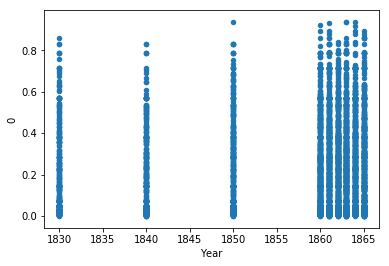

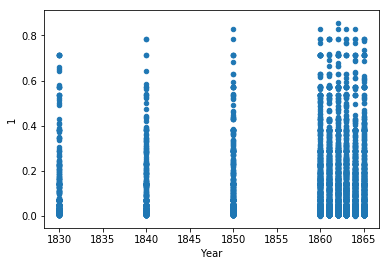

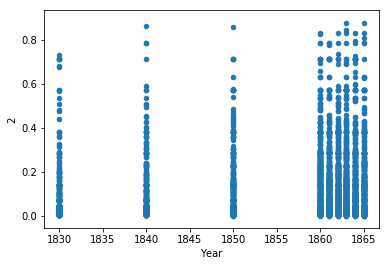

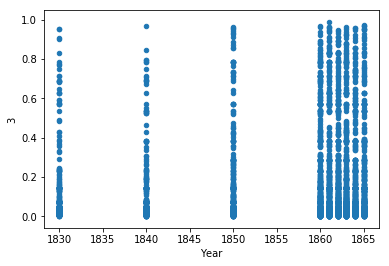

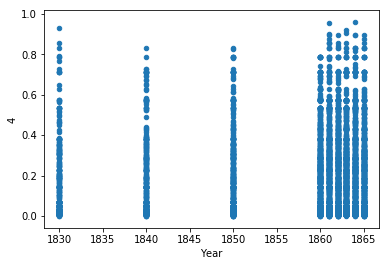

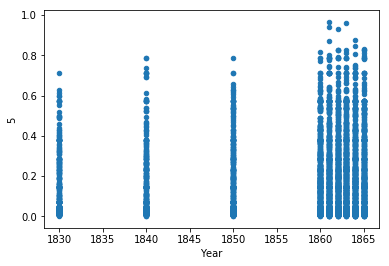

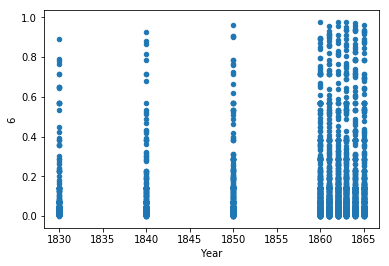

In [37]:
for i in np.arange(7):
    meta.plot.scatter(x='Year', y=i)

In [38]:
lda_model.perplexity(count_vect.transform(test_strings))
#The lower the perplexity, the better the fit of the model. 

2734.052129859233

In [40]:
array_sums = make_array()
for i in np.arange(7):
    sum_for_year = sum(meta[i])
    array_sums = np.append(array_sums, sum_for_year)

array_sums #sum of proportions for each topic

array([ 1279.32628705,   783.41089245,   685.23782143,   802.45970328,
        1177.83855559,   970.19781569,   601.52892449])

In [41]:
array_of_years = make_array(1830, 1840, 1850, 1860, 1861, 1862, 1863, 1864, 1865 )
total_list_of_prop = []
total_list_of_std = []
for i in np.arange(7):
    array_of_prop_i = make_array()
    array_of_std_i = make_array()
    for year in array_of_years:
        one_year_prop = meta[ meta['Year'] == year]
        avg_prop_for_year = np.average(one_year_prop[i])
        std_dev_for_year = np.std(one_year_prop[i])
        array_of_prop_i = np.append(array_of_prop_i, avg_prop_for_year)
        array_of_std_i = np.append(array_of_std_i, std_dev_for_year)
    total_list_of_prop.append(array_of_prop_i)
    total_list_of_std.append(array_of_std_i)
total_list_of_prop


[array([ 0.20686034,  0.20108719,  0.20325673,  0.19713227,  0.20861103,
         0.20319432,  0.20207417,  0.20321795,  0.20363573]),
 array([ 0.13234611,  0.12393635,  0.12423666,  0.12385321,  0.12544298,
         0.1337891 ,  0.12001494,  0.1151146 ,  0.12435514]),
 array([ 0.10515887,  0.11427073,  0.11269132,  0.1152373 ,  0.10417588,
         0.1043222 ,  0.10934168,  0.10985507,  0.10654403]),
 array([ 0.1310277 ,  0.11218104,  0.13231458,  0.13687782,  0.12899006,
         0.13036049,  0.12353822,  0.12429361,  0.12069163]),
 array([ 0.18368415,  0.19544836,  0.18902124,  0.18002146,  0.18847858,
         0.1890607 ,  0.18908753,  0.18764923,  0.18423919]),
 array([ 0.14672139,  0.15809661,  0.13999158,  0.14926065,  0.15230163,
         0.15211884,  0.16178512,  0.15935823,  0.15898952]),
 array([ 0.09420144,  0.09497973,  0.0984879 ,  0.09761728,  0.09199983,
         0.08715434,  0.09415834,  0.10051131,  0.10154476])]

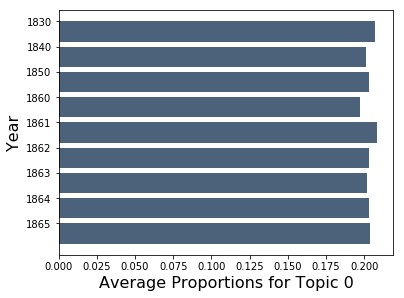

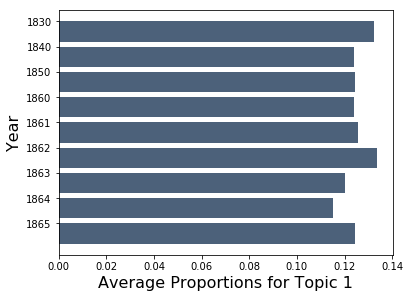

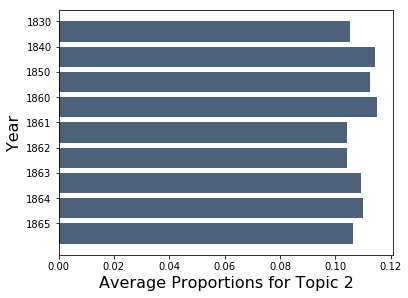

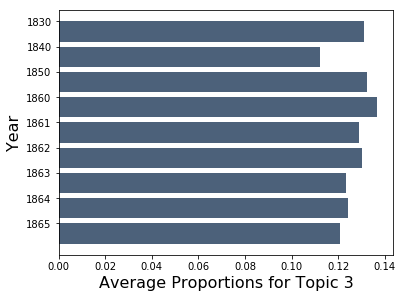

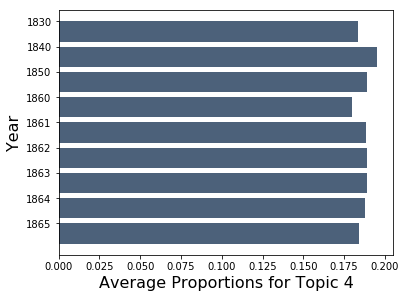

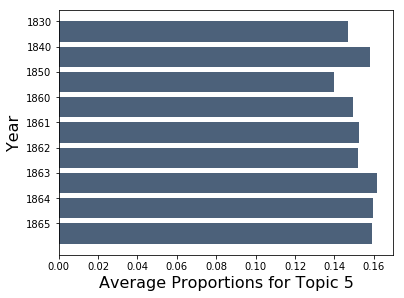

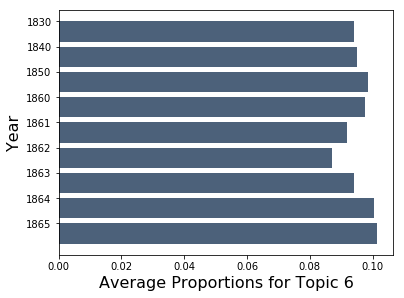

In [42]:
topic_num = 0
for arr in total_list_of_prop:
    prop_title = 'Average Proportions for Topic ' + str(topic_num)
    topic_table = Table().with_columns(
        'Year', array_of_years,
        prop_title, arr 
    )
    topic_table.barh('Year', prop_title)
    topic_num+=1

#bar charts showing average proportions of each topic from the article contents thorughout the years

In [43]:
#http://www.scipy-lectures.org/packages/statistics/index.html#student-s-t-test-the-simplest-statistical-test

test_stats = make_array()
p_values = make_array()

for i in np.arange(7):
    data_1830 = meta[ meta['Year'] == 1830][i]
    data_1865 = meta[ meta['Year'] == 1865][i] #ith topic, year 1860
    twosample_results = scipy.stats.ttest_ind(data_1830, data_1865) #2sample t test
    test_stats = np.append(test_stats, twosample_results[0])
    p_values = np.append(p_values, twosample_results[1])

stat_results = Table().with_columns(
    'Topic', np.arange(7),
    'Test Statistics', test_stats,
    'P-values', p_values
)
    
stat_results
#p-value is 0.05, since none of p_values are below that, we fail to reject the null hypothesis for article contents that the occurence of the topics didn't
#change too dramatically from 1830 to 1865


Topic,Test Statistics,P-values
0,0.23133,0.817101
1,0.757728,0.448776
2,-0.150885,0.880094
3,0.788074,0.430823
4,-0.043059,0.965662
5,-1.06626,0.286538
6,-0.666966,0.504934


In [44]:
#We will perform topic modeling for the titles
title_strings = []
for article in article_titles:
    title_strings.append(article)

In [45]:
count_vect2 = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)
random.shuffle(title_strings) #shuffle the title strings list
train_titles = title_strings[:3150]
test_titles = title_strings[3150:]

In [46]:
dtm2 = count_vect2.fit_transform(train_titles)
dtm_feature_names2 = count_vect2.get_feature_names()
dtm_feature_names2[:10]

['1826',
 '1840',
 '1864',
 '1865',
 '228',
 '93the',
 'accepted',
 'advertisement',
 'advice',
 'agency']

In [47]:
lda2 = LatentDirichletAllocation(n_components=8, max_iter=5)
np.random.seed(0)

In [48]:
lda_model2 = lda2.fit(dtm2)

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [49]:
pickle.dump((lda2, lda_model2, dtm2, count_vect2), open('8 title-topics.pkl', 'wb'))
lda2, lda_model2, dtm2, count_vect2 = pickle.load(open('8 title-topics.pkl', 'rb'))
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model2, dtm2, count_vect2)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      15.588317        1       1  0.279751  0.001300
5      14.552117        1       2  0.294648  0.054600
7      14.518343        1       3 -0.052818 -0.360958
1      13.671082        1       4 -0.153417  0.182216
4      12.097287        1       5 -0.154009  0.066515
0      11.916981        1       6 -0.022166  0.101256
6       9.334372        1       7 -0.099431 -0.111746
3       8.321500        1       8 -0.092557  0.066816, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
222   Default  198.000000            lady  198.000000  30.0000  30.0000
134   Default  103.000000      embroidery  103.000000  29.0000  29.0000
43    Default  141.000000            book  141.000000  28.0000  28.0000
172   Default   90.000000           godey   90.000000  27.0000  27.0000
280   Default  105.000000             new  105.000000  26.0000  26.0000
447   Default   73.000000           young   73.000000  25.0000  25.0000
124   Default   63.000000           dress   63.000000  24.0000  24.0000
395   Default   68.000000           table   68.000000  23.0000  23.0000
304   Default   69.000000    philadelphia   69.000000  22.0000  22.0000
301   Default   62.000000         pattern   62.000000  21.0000  21.0000
115   Default   59.000000     description   59.000000  20.0000  20.0000
147   Default   56.000000         fashion   56.000000  19.0000  19.0000
101   Default   53.000000         crochet   53.000000  18.0000  18.0000
442   Default   55.000000         written   55.000000  17.0000  17.0000
145   Default   46.000000           fancy   46.000000  16.0000  16.0000
179   Default   38.000000            hair   38.000000  15.0000  15.0000
312   Default   50.000000           plate   50.000000  14.0000  14.0000
386   Default   45.000000     subscribers   45.000000  13.0000  13.0000
149   Default   59.000000        fashions   59.000000  12.0000  12.0000
114   Default   58.000000      department   58.000000  11.0000  11.0000
52    Default   42.000000        braiding   42.000000  10.0000  10.0000
221   Default   55.000000          ladies   55.000000   9.0000   9.0000
230   Default   40.000000         letters   40.000000   8.0000   8.0000
74    Default   31.000000        children   31.000000   7.0000   7.0000
380   Default   40.000000           steel   40.000000   6.0000   6.0000
94    Default   31.000000  correspondents   31.000000   5.0000   5.0000
68    Default   35.000000         chapter   35.000000   4.0000   4.0000
284   Default   39.000000          notice   39.000000   3.0000   3.0000
258   Default   39.000000   miscellaneous   39.000000   2.0000   2.0000
433   Default   29.000000           woman   29.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
74     Topic8   30.165361        children   31.023517   2.4583  -2.9213
433    Topic8   28.266416           woman   29.083153   2.4578  -2.9863
342    Topic8   24.090935            robe   24.907937   2.4530  -3.1462
56     Topic8   21.157905           cakes   21.974222   2.4485  -3.2760
434    Topic8   19.928572           women   20.747143   2.4461  -3.3358
408    Topic8   18.785168          toilet   19.601967   2.4438  -3.3949
324    Topic8   18.220653        puddings   19.037069   2.4425  -3.4254
234    Topic8   13.773007           lines   14.589871   2.4287  -3.7053
294    Topic8   13.227685       ornaments   14.043959   2.4264  -3.7457
212    Topic8   12.593022            july   13.414569   2.4231  -3.7949
49     Topic8   12.149713       bracelets   12.965996   2.4213  -3.8307
431    Topic8   12.149681         wishing   12.966071   2.4213  -3.8307
267    Topic8   11.136002          mother   11.956257   2.4153  -3.9178
320    Topic8   10.130045         present   10.951050   2.4084  -4.0125
300    Topic8    9.555476       p

In [50]:
display_topics(lda2, dtm_feature_names2, 20)

0 new dress fancy letters department chapter child juvenile marking flowers spring braided alphabet flower lessons tableaux beauty baby shoe walking
1 young pattern crochet braiding ladies day literary notices miss boarding life school hale lesson tale mr mrs city morning 1826
2 godey philadelphia fashions new composed little book lady piano york agency chitchat old chair forte music arm receipts girl november
3 hair children woman robe cakes women toilet puddings lines ladies ornaments july bracelets wishing mother present patchwork aunt reminiscences management
4 style health letter story department mrs family home cottage year hints evening casket drawing lace house friends bag wilson latest
5 lady book table written subscribers notice editors work knitted bonnets summer pincushion editor case knitting winter heart netting centre cap
6 correspondents following articles patterns accepted christmas madame demorest establishment number french gossip country mat netted beautiful notes h

In [51]:
doc_topic2 = lda2.transform(dtm2)
list_of_doctopics2 = [doc_topic2[n] for n in range(len(doc_topic2))]
list_of_doctopics2[3149] # propotion of each topic in the certain article number given, is the length of train_titles, which is half of title_strings

array([ 0.02083372,  0.02087275,  0.68750498,  0.02083334,  0.18745521,
        0.02083333,  0.02083334,  0.02083333])

In [52]:
df2 = pd.DataFrame(list_of_doctopics2)
df2 # columns are topics and rows are documents/articles, shows probabilty of each topic in a document, we just show the first 5 documents here

,0,1,2,3,4,5,6,7
0,0.017869,0.017857,0.874987,0.017857,0.017857,0.017858,0.017857,0.017857
1,0.708304,0.041667,0.041667,0.041667,0.041696,0.041667,0.041667,0.041667
2,0.562500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
3,0.041667,0.041667,0.708331,0.041667,0.041667,0.041667,0.041669,0.041667
4,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
5,0.062500,0.062500,0.062500,0.562500,0.062500,0.062500,0.062500,0.062500
6,0.062500,0.062500,0.062500,0.562500,0.062500,0.062500,0.062500,0.062500
7,0.562500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
8,0.041667,0.708333,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
9,0.041667,0.041667,0.041689,0.041667,0.041667,0.708311,0.041667,0.041667


In [53]:
meta_titles_prev =meta_table.to_df()
meta_titles_prev[df2.columns] = df2
meta_titles = meta_titles_prev[:3150] 

In [54]:
meta_titles.corr()

,Year,0,1,2,3,4,5,6,7
Year,1.000000,-0.012170,0.012823,0.005249,-0.039550,-0.002790,0.023081,-0.016626,0.015629
0,-0.012170,1.000000,-0.131908,-0.164306,-0.091972,-0.131129,-0.155450,-0.129862,-0.135845
1,0.012823,-0.131908,1.000000,-0.170164,-0.119302,-0.133684,-0.165324,-0.128120,-0.167923
2,0.005249,-0.164306,-0.170164,1.000000,-0.128149,-0.150348,-0.162371,-0.137282,-0.161895
3,-0.039550,-0.091972,-0.119302,-0.128149,1.000000,-0.115777,-0.131429,-0.066382,-0.130570
4,-0.002790,-0.131129,-0.133684,-0.150348,-0.115777,1.000000,-0.169521,-0.118504,-0.174528
5,0.023081,-0.155450,-0.165324,-0.162371,-0.131429,-0.169521,1.000000,-0.141810,-0.191092
6,-0.016626,-0.129862,-0.128120,-0.137282,-0.066382,-0.118504,-0.141810,1.000000,-0.152533
7,0.015629,-0.135845,-0.167923,-0.161895,-0.130570,-0.174528,-0.191092,-0.152533,1.000000


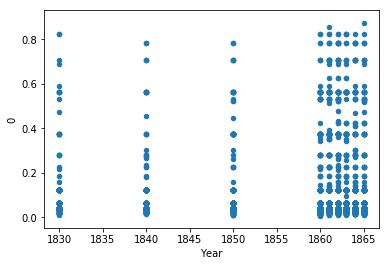

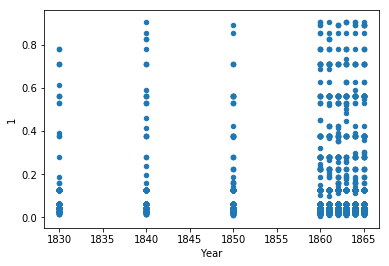

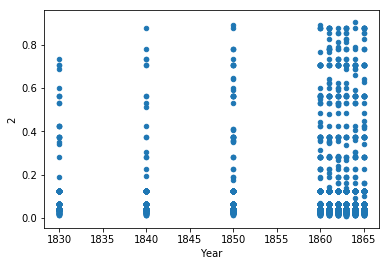

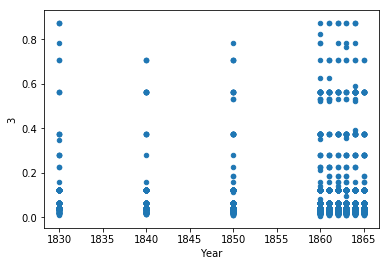

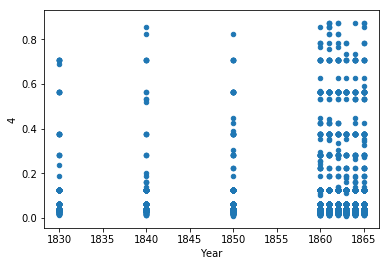

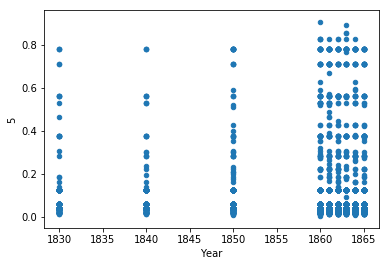

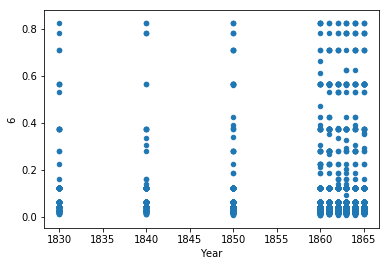

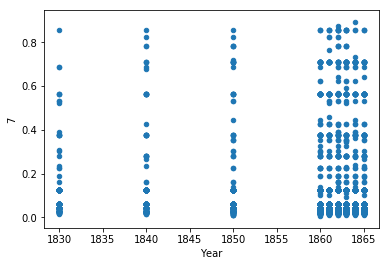

In [55]:
for i in np.arange(8):
    meta_titles.plot.scatter(x='Year', y=i)


In [56]:
array_of_years = make_array(1830, 1840, 1850, 1860, 1861, 1862, 1863, 1864, 1865 )
list_of_title_prop = []
for i in np.arange(8):
    array_of_prop_i = make_array()
    for year in array_of_years:
        one_year_prop = meta_titles[ meta_titles['Year'] == year]
        avg_prop_for_year = np.average(one_year_prop[i])
        array_of_prop_i = np.append(array_of_prop_i, avg_prop_for_year)
    list_of_title_prop.append(array_of_prop_i)
list_of_title_prop

[array([ 0.13224346,  0.12968746,  0.12126   ,  0.11982043,  0.12803379,
         0.13502806,  0.11949546,  0.12460682,  0.11639592]),
 array([ 0.11692749,  0.14271795,  0.11379725,  0.12511557,  0.1313741 ,
         0.12454781,  0.12923861,  0.1257    ,  0.14070569]),
 array([ 0.12791341,  0.11310269,  0.14215708,  0.12291298,  0.12943271,
         0.12663746,  0.13086087,  0.11943995,  0.13873426]),
 array([ 0.12295879,  0.10980473,  0.10516077,  0.10826679,  0.08972961,
         0.09326286,  0.09423422,  0.11778499,  0.09113264]),
 array([ 0.13645559,  0.12463963,  0.12362987,  0.1338008 ,  0.13851808,
         0.13434458,  0.11384073,  0.12249079,  0.13412571]),
 array([ 0.12492117,  0.1193862 ,  0.13557779,  0.14840984,  0.14349853,
         0.13536346,  0.14102507,  0.14220218,  0.13116092]),
 array([ 0.11759443,  0.10808175,  0.12157617,  0.10327513,  0.10643495,
         0.09624655,  0.10952042,  0.11534208,  0.10933407]),
 array([ 0.12098567,  0.15257959,  0.13684106,  0.13839

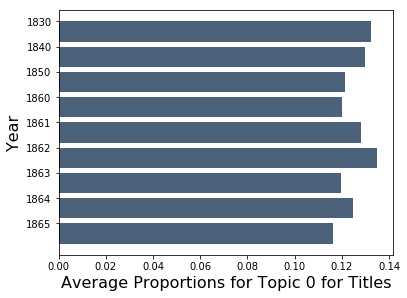

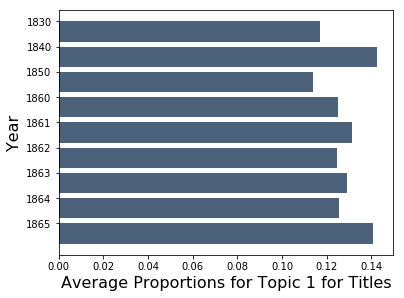

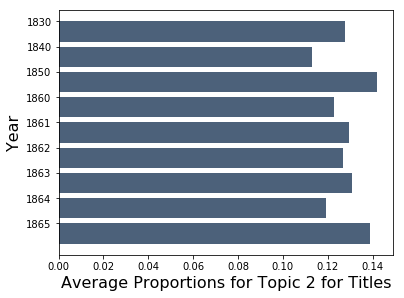

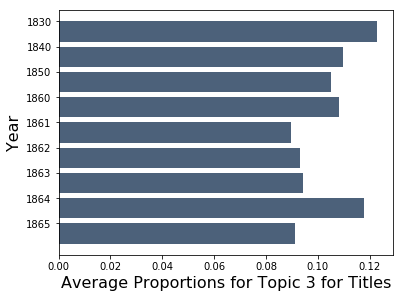

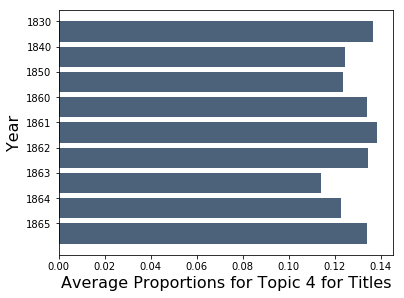

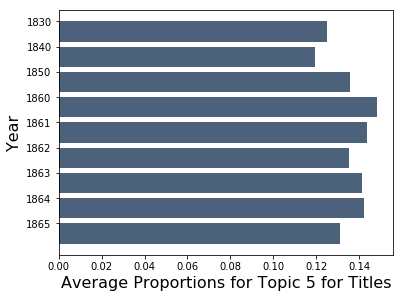

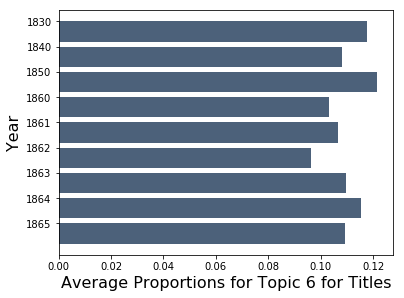

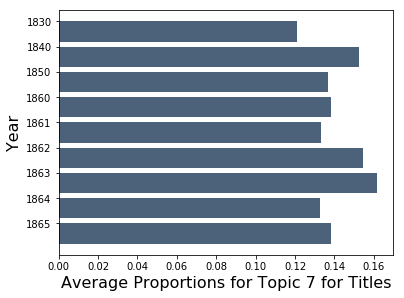

In [57]:
title_topic_num = 0
for arr in list_of_title_prop:
    prop_title = 'Average Proportions for Topic ' + str(title_topic_num) + " for Titles"
    topic_table = Table().with_columns(
        'Year', array_of_years,
        prop_title, arr 
    )
    topic_table.barh('Year', prop_title)
    title_topic_num+=1

#bar charts showing average proportions of each topic from the article titles throughout the years

In [58]:
#http://www.scipy-lectures.org/packages/statistics/index.html#student-s-t-test-the-simplest-statistical-test

test_title_stats = make_array()
p_title_values = make_array()

for i in np.arange(8):
    data_1830 = meta_titles[ meta_titles['Year'] == 1830][i]
    data_1865 = meta_titles[ meta_titles['Year'] == 1865][i] 
    twosample_results = scipy.stats.ttest_ind(data_1830, data_1865) #2 sample t-test

    test_title_stats = np.append(test_title_stats, twosample_results[0])
    p_title_values = np.append(p_title_values, twosample_results[1])

stat_title_results = Table().with_columns(
    'Topic', np.arange(8),
    'Test Statistics for Titles', test_title_stats,
    'P-values for Titles', p_title_values
)

stat_title_results

#p-value is 0.05, so we fail to reject null hypthesis that occureence of topics in the titles did not change too dramatically from 1830 to 1865.

Topic,Test Statistics for Titles,P-values for Titles
0,1.04545,0.296258
1,-1.36626,0.172396
2,-0.59696,0.550772
3,2.52321,0.0119003
4,0.139173,0.889363
5,-0.373554,0.708875
6,0.543268,0.587158
7,-1.0553,0.291735
